https://www.kaggle.com/andreagarritano/simple-data-augmentation-with-imgaug

In [3]:
import pandas as pd
import numpy as np
import imgaug as iaa
import cv2
import os
import matplotlib.pyplot as plt

In [4]:
data_path = './data'
train_csv_path = os.path.join(data_path,'train.csv')
train_image_path = os.path.join(data_path,'train_images')

In [5]:
train = pd.read_csv('./data/train.csv')

In [6]:
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [7]:
train = train.fillna(-1)

In [8]:
# Create filename and label column
train[['Image', 'Label']] = train['Image_Label'].str.split('_', expand=True)
train = train.drop('Image_Label', axis=1)

In [9]:
train.head() 

,EncodedPixels,Image,Label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,-1,0011165.jpg,Gravel
3,-1,0011165.jpg,Sugar
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


Below are functions used in Kaggle to create masks and segmentation maps

`rle2mask` Takes in the EncodedPixels column and converts creates a mask of the image. It returns the mask.

In [10]:
def rle2mask(rle_string, height, width):
    '''
    convert RLE(run length encoding) string to numpy array

    Parameters: 
    rle_string (str): string of rle encoded mask
    height (int): height of the mask
    width (int): width of the mask 

    Returns: 
    numpy.array: numpy array of the mask
    '''
    
    rows, cols = height, width
    
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)
    img = np.zeros(rows*cols, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img



`mask2rle` takes in a mask and converts it to encoded pixels. It returns a list of encoded pixels.

In [11]:
# credits: https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)




The `create_segmap` function creates a `imgaug.augmentables.segmaps.SegmentationMapsOnImage` object that contains the original image and the mask(s). It takes in the row number to do this. 

In [12]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
# credit: https://www.kaggle.com/aleksandradeis/understanding-clouds-eda
def create_segmap(row_id):
    '''
    Helper function to create a segmentation map for an image by row identifier
    '''
    # open the image
    path = os.path.join(train_image_path, df.loc[row_id, : ]['Image'])
    image = cv2.imread(path)
    
    # get mask
    mask1 = get_mask(row_id)
    mask2 = get_mask(row_id + 1)
    mask3 = get_mask(row_id + 2)
    mask4 = get_mask(row_id + 3)
    
    # label numpy map with 4 classes
    segmap = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.int32)
    segmap[:,:,0] = np.where(mask1==1, 1, segmap[:,:,0])
    segmap[:,:,1] = np.where(mask2==1, 2, segmap[:,:,0])
    segmap[:,:,2] = np.where(mask3==1, 3, segmap[:,:,0])
    segmap[:,:,3] = np.where(mask4==1, 4, segmap[:,:,0])
    
    # create a segmantation map
    segmap = SegmentationMapsOnImage(segmap, shape=image.shape)
    
    return segmap


Creates a binary map, converts 255 to 1

In [13]:
def get_mask(row_id):
    '''
    Function to get the mask of a image from a single rle
    INPUT:
        row_id - identifier of datagrame
    RETURNS:
        np_mask - numpy segmentation map
    '''
    path = os.path.join(train_image_path, df.loc[row_id, : ]['Image'])
    image = cv2.imread(path)

    rle = df['EncodedPixels'].values[row_id]
    if rle != -1:
        np_mask = rle2mask(rle, np.asarray(image).shape[0], np.asarray(image).shape[1])
        np_mask = np.clip(np_mask, 0, 1) # Creates a binary map. i.e. converts all mask pixels to 1 and background to 0
    else:
        # empty mask
        np_mask = np.zeros((np.asarray(image).shape[0], np.asarray(image).shape[1]))
        
    return np_mask

In [14]:
df = train

In [15]:
segmap = create_segmap(0)

In [16]:
segmap.shape

(1400, 2100, 3)

In [151]:
mask = get_mask(0)

In [152]:
image = plt.imread('./data/train_images/0011165.jpg')

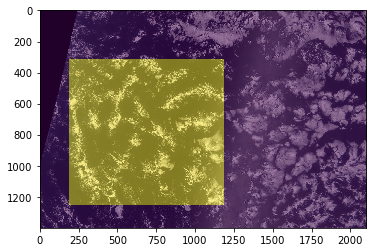

In [153]:
plt.imshow(image)
plt.imshow(mask, alpha=0.5)

In [169]:
df['Image'][0]

'0011165.jpg'

In [162]:
import imgaug.augmenters as iaa
import imgaug.imgaug

def augment(image_id, seq):
    image_path = os.path.join(train_image_path, df['Image'][cloud_img_id])
    print(image_path)
    image = cv2.imread(image_path)
    segmap = create_segmap(cloud_img_id)
    
    # apply augmentation for image and mask
    image_aug, segmap_aug = seq(image=image, segmentation_maps=segmap)
     
    mask = segmap_aug.get_arr()
    augmented_rle = mask2rle(mask)

    return (image_aug, augmented_rle, mask, segmap_aug)



In [35]:
def plt_image(img1, mask1, img2, mask2):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,30))

    ax1.imshow(img1)
    mask1 = np.ma.masked_where(mask1 == 0, mask1)
    ax1.imshow(mask1, alpha=0.75)

    ax2.imshow(img2)
    mask2 = np.ma.masked_where(mask2 == 0, mask2)
    ax2.imshow(mask2, alpha=0.75)

./data/train_images/582a2f9.jpg


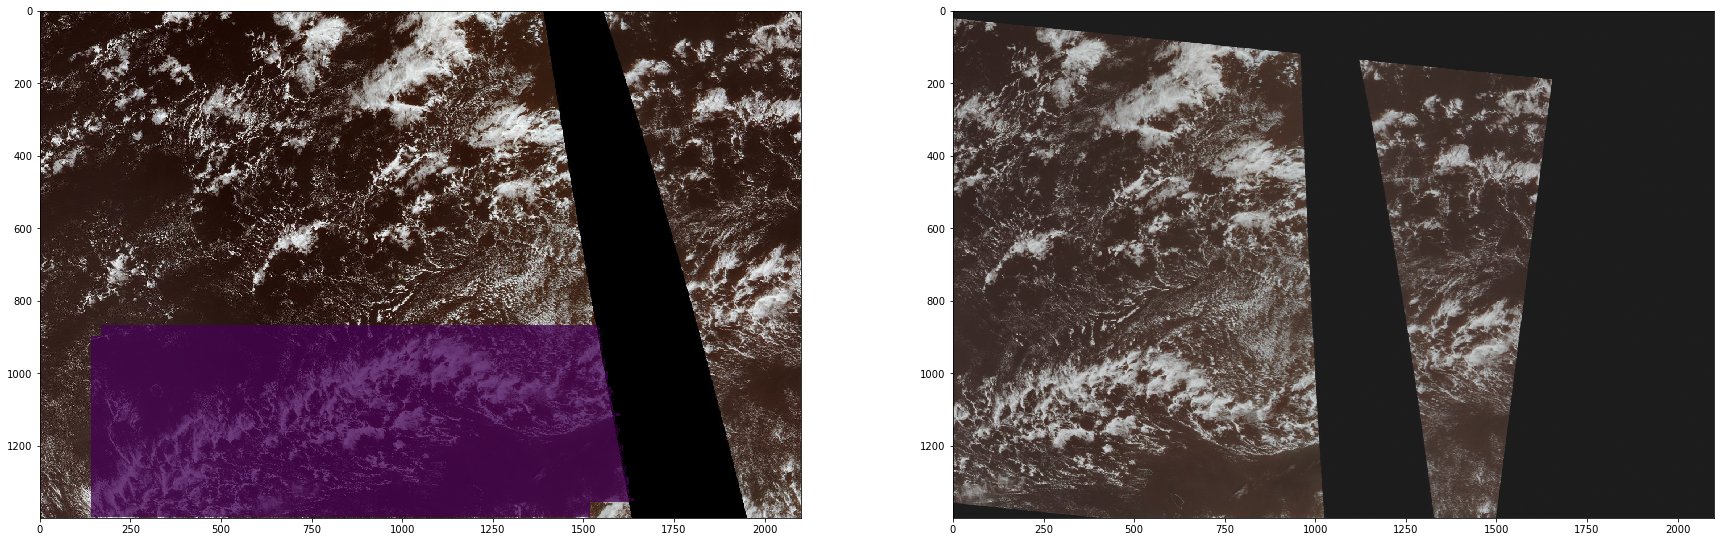

In [173]:
cloud_img_id = df.sample().index[0] # get a random index

image_path = os.path.join(train_image_path, df['Image'][cloud_img_id])
clouds_img = cv2.imread(image_path)

# Define our augmentation pipeline.
# You can find more augmenters here: https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

(image_aug, augmented_rle, augmented_mask, augmented_segmap) = augment(cloud_img_id, seq)

plt_image(img1=clouds_img, mask1=get_mask(cloud_img_id), img2=image_aug, mask2=augmented_mask)